### https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba

https://github.com/cerndb/dist-keras

In [4]:
pip install keras

     |████████████████████████████████| 378kB 6.7MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [35]:
df = pd.read_json('event_10_2018.json')
print('Number of rows and columns:', df.shape)

Number of rows and columns: (27231, 25)


In [36]:
# Removing unnecessary columns
del df['date8_val']
del df['_id']
del df['url']

In [45]:
df.columns.values
df.dtypes

code                      float64
country_code               object
date8                       int64
day                         int64
geoname                    object
goldstein                 float64
id                         object
latitude                   object
longitude                  object
month                       int64
quad_class                float64
root_code                 float64
source                     object
source_text                object
src_actor                  object
src_agent                  object
src_other_agent            object
target                     object
tgt_actor                  object
tgt_agent                  object
tgt_other_agent            object
year                        int64
datestamp          datetime64[ns]
dtype: object

In [38]:
df.head(5)

,code,country_code,date8,day,geoname,goldstein,id,latitude,longitude,month,quad_class,root_code,source,source_text,src_actor,src_agent,src_other_agent,target,tgt_actor,tgt_agent,tgt_other_agent,year
0,60.0000,UKR,20181012,12,Ukraine,6.0000,5bc0e3beff261b4fdacb191b_3,49.0000,32.0000,10,2.0000,6.0000,RUS,bbc,RUS,,,---MIL,,MIL,,2018
1,30.0000,RUS,20181012,12,Russian Federation,4.0000,5bc0e3c3ff261b4fdacb191f_1,60.0000,100.0000,10,1.0000,3.0000,RUSGOV,bbc,RUS,GOV,,---RAD,,,RAD,2018
2,10.0000,CHN,20181012,12,Beijing Beijing Shi,0.0000,5bc0e842ff261b5574cb1903_1,39.9075,116.3972,10,0.0000,1.0000,---GOV,wn_asia,,GOV,,CHN,CHN,,,2018
3,30.0000,CHN,20181012,12,Taishan,4.0000,5bc0e842ff261b5574cb1903_3,22.2513,112.7799,10,1.0000,3.0000,USA,wn_asia,USA,,,USA,USA,,,2018
4,160.0000,HKG,20181012,12,Hong Kong,-4.0000,5bc0e842ff261b5574cb1903_5,22.2783,114.1747,10,3.0000,16.0000,USAGOV,wn_asia,USA,GOV,,HKG,HKG,,,2018


In [39]:
#Convert date to datetime format and name the new column as datestamp
df['datestamp']=pd.to_datetime(df[['year','month','day']])

In [40]:
df.head()

,code,country_code,date8,day,geoname,goldstein,id,latitude,longitude,month,quad_class,root_code,source,source_text,src_actor,src_agent,src_other_agent,target,tgt_actor,tgt_agent,tgt_other_agent,year,datestamp
0,60.0000,UKR,20181012,12,Ukraine,6.0000,5bc0e3beff261b4fdacb191b_3,49.0000,32.0000,10,2.0000,6.0000,RUS,bbc,RUS,,,---MIL,,MIL,,2018,2018-10-12
1,30.0000,RUS,20181012,12,Russian Federation,4.0000,5bc0e3c3ff261b4fdacb191f_1,60.0000,100.0000,10,1.0000,3.0000,RUSGOV,bbc,RUS,GOV,,---RAD,,,RAD,2018,2018-10-12
2,10.0000,CHN,20181012,12,Beijing Beijing Shi,0.0000,5bc0e842ff261b5574cb1903_1,39.9075,116.3972,10,0.0000,1.0000,---GOV,wn_asia,,GOV,,CHN,CHN,,,2018,2018-10-12
3,30.0000,CHN,20181012,12,Taishan,4.0000,5bc0e842ff261b5574cb1903_3,22.2513,112.7799,10,1.0000,3.0000,USA,wn_asia,USA,,,USA,USA,,,2018,2018-10-12
4,160.0000,HKG,20181012,12,Hong Kong,-4.0000,5bc0e842ff261b5574cb1903_5,22.2783,114.1747,10,3.0000,16.0000,USAGOV,wn_asia,USA,GOV,,HKG,HKG,,,2018,2018-10-12


In [41]:
#Convert target variable to numeric (root code)
df['root_code'] = pd.to_numeric(df['root_code'], errors='coerce')

In [42]:
df = df.dropna(subset=['root_code'])

In [47]:
df['datestamp']=pd.to_datetime(df['datestamp']) 

In [48]:
df['quarter'] = df['datestamp'].apply(lambda x: x.quarter)

In [49]:
df=df.loc[:,['datestamp','root_code', 'year','quarter','month','day']]

In [50]:
df.sort_values('datestamp', inplace=True, ascending=True)

In [51]:
df = df.reset_index(drop=True)

In [53]:
df["weekday"]=df.apply(lambda row: row["datestamp"].weekday(),axis=1)

In [54]:
df["weekday"] = (df["weekday"] < 5).astype(int)

In [55]:
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.datestamp.min())
print('The time series ends on: ', df.datestamp.max())

Number of rows and columns after removing missing values: (26727, 7)
The time series starts from:  2018-10-12 00:00:00
The time series ends on:  2018-10-27 00:00:00


In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [56]:
stat, p = stats.normaltest(df.root_code)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=4649.548, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: -0.8214883184266721
Skewness of normal distribution: 0.7781918571978164


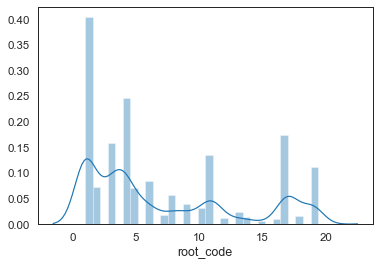

In [58]:
sns.distplot(df.root_code);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.root_code)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.root_code)))

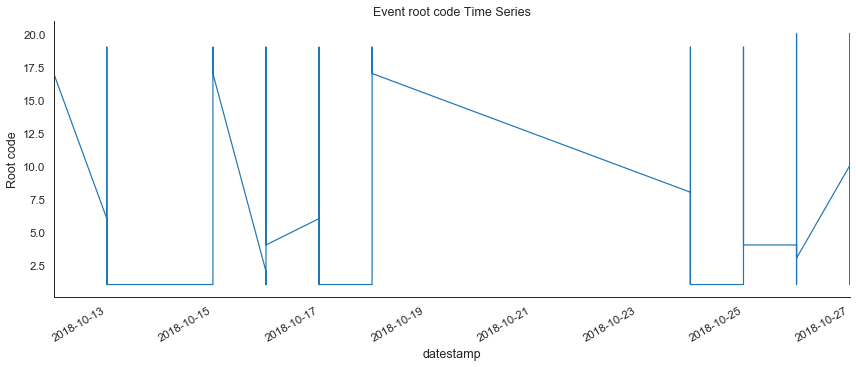

In [59]:
df1=df.loc[:,['datestamp','root_code']]
df1.set_index('datestamp',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Root code')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Event root code Time Series')
sns.despine(top=True)
plt.show();

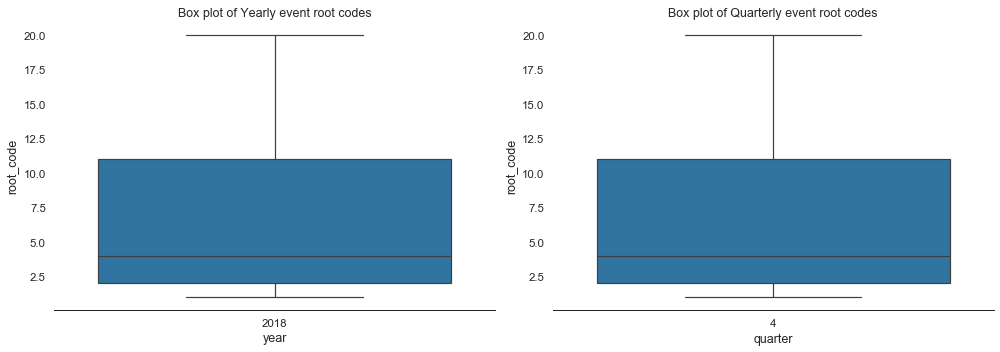

In [60]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="root_code", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly event root codes')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="root_code", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly event root codes')
sns.despine(left=True)
plt.tight_layout();

,count,mean,std,min,25%,50%,75%,max
root_code,26727.0000,7.0491,6.0924,1.0000,2.0000,4.0000,11.0000,20.0000


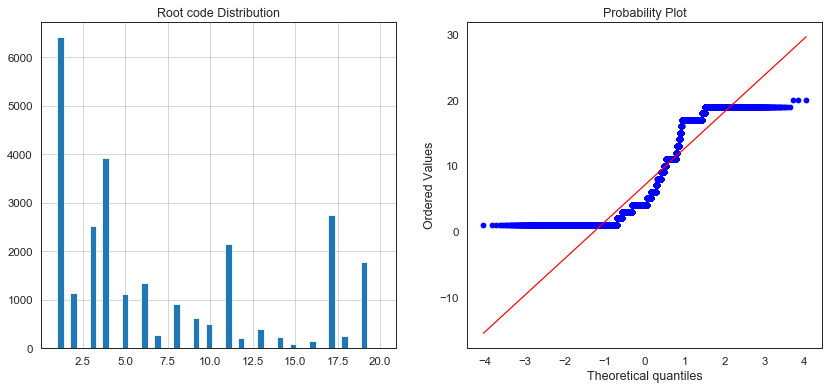

In [61]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['root_code'].hist(bins=50)
plt.title('Root code Distribution')
plt.subplot(1,2,2)
stats.probplot(df['root_code'], plot=plt);
df1.describe().T

In [62]:
dataset = df.root_code.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 70
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [63]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

W1207 13:40:42.060520 4684115392 deprecation_wrapper.py:119] From /Users/maleeha/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 21350 samples, validate on 5315 samples
Epoch 1/20
21350/21350 [==============================] - 1s 41us/step - loss: 0.1051 - val_loss: 0.1069
Epoch 2/20
21350/21350 [==============================] - 1s 24us/step - loss: 0.1027 - val_loss: 0.1067
Epoch 3/20
21350/21350 [==============================] - 1s 25us/step - loss: 0.1022 - val_loss: 0.1066
Epoch 4/20
21350/21350 [==============================] - 1s 25us/step - loss: 0.1021 - val_loss: 0.1067
Epoch 5/20
21350/21350 [==============================] - 1s 31us/step - loss: 0.1020 - val_loss: 0.1067
Epoch 6/20
21350/21350 [==============================] - 1s 31us/step - loss: 0.1018 - val_loss: 0.1067
Epoch 7/20
21350/21350 [==============================] - 1s 24us/step - loss: 0.1018 - val_loss: 0.1067
Epoch 8/20
21350/21350 [==============================] - 0s 23us/step - loss: 0.1017 - val_loss: 0.1067
Epoch 9/20
21350/21350 [==============================] - 1s 25us/step - loss: 0.1017 - val_loss: 0.1067
Epoch 

In [64]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 5.244488814232709
Train Root Mean Squared Error: 6.036732866105049
Test Mean Absolute Error: 5.4002006867713
Test Root Mean Squared Error: 6.20689266769849


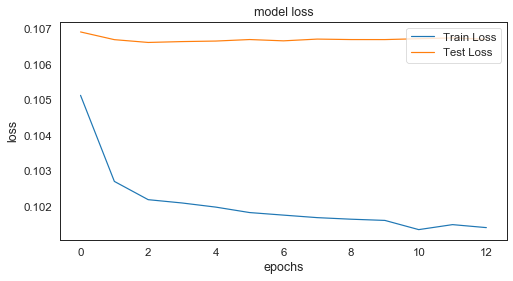

In [65]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

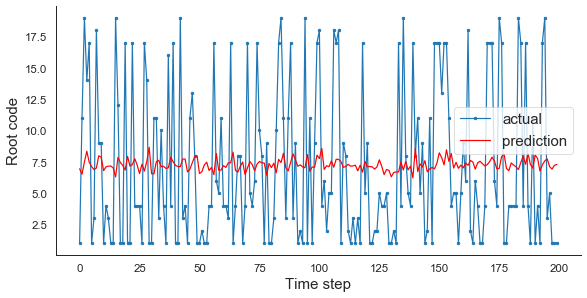

In [67]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Root code', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();